In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sbs
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%pylab inline

import warnings 
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [18]:
dd = pd.read_excel('Market Data.xlsx')

In [19]:

dd = dd[dd['DataDate'] > '1998-01-31']
dd = dd[dd.Iid == '01']
dd = dd.sort_values(by = ['GVKey', 'DataDate'])
dd.reset_index(inplace = True)
dd = dd[['DataDate', 'GVKey', 'MkVal']]
dd = dd.rename(columns = {'MkVal': 'MK'})

In [20]:
naming = pd.read_excel('my_excel_file.xlsx')
##
#dd['Doxod1'] = dd.groupby('FIRM')['MK'].pct_change()
#dd['Doxod3'] = dd.groupby('FIRM')['MK'].pct_change(periods=3)
#dd['Doxod12'] = dd.groupby('FIRM')['MK'].pct_change(periods=12)

##
#dd['yield_month'] = dd['Doxod1'].shift(-1)
#dd['yield_quarter'] = dd['Doxod3'].shift(-3)
#dd['yield_year'] = dd['Doxod12'].shift(-12)

#dd['yield_month']=dd['yield_month']*100
#dd['yield_quarter']=dd['yield_quarter']*100
#dd['yield_year']=dd['yield_year']*100
##

dd['shifted_1'] = dd.groupby('GVKey')['MK'].apply(lambda x: np.log(x.shift(-1) /x))

dd['shifted_3'] = dd.groupby('GVKey')['MK'].apply(lambda x: np.log(x.shift(-3) /x)) 

dd['shifted_6'] = dd.groupby('GVKey')['MK'].apply(lambda x: np.log(x.shift(-6) /x)) 

dd['shifted_12'] = dd.groupby('GVKey')['MK'].apply(lambda x: np.log(x.shift(-12) /x))

list = []
for element in dd['GVKey']:
    if element in np.array(naming['GVKey']):
        list.append(1)
    else:
        list.append(0)

dd['indexing'] = list
dd = dd[dd.indexing == 1]

dd['company'] = 'new_name'
dd['label'] = 'new_label'
for element in np.array(naming['GVKey']):
    dd['company'][dd['GVKey'] == element] = np.array(naming['Company'][naming['GVKey'] == element])[0]
    dd['label'][dd['GVKey'] == element] = np.array(naming['Label'][naming['GVKey'] == element])[0]
    
dd = dd[['DataDate', 'company', 'label', 'MK', 'shifted_1', 'shifted_3', 'shifted_6', 'shifted_12']]

dd['log_MK'], _ = stats.boxcox(dd['MK'])

In [21]:
initial = pd.read_excel('features_merge.xlsx') 
initial = initial[['company', 'Sector']]
dd = pd.merge(dd, initial, how= 'left', on = 'company').drop_duplicates()

In [22]:
z = dd.groupby(['DataDate','Sector'])['MK'].sum()
z = pd.DataFrame(z).reset_index().sort_values(['Sector', 'DataDate'])
z = z.drop_duplicates()

In [23]:
z['shifted_1_sec'] = z.groupby('Sector')['MK'].apply(lambda x: np.log(x.shift(-1) /x))

z['shifted_3_sec'] = z.groupby('Sector')['MK'].apply(lambda x: np.log(x.shift(-3) /x)) 

z['shifted_6_sec'] = z.groupby('Sector')['MK'].apply(lambda x: np.log(x.shift(-6) /x)) 

z['shifted_12_sec'] = z.groupby('Sector')['MK'].apply(lambda x: np.log(x.shift(-12) /x))

In [24]:
dd = pd.merge(dd, z[['DataDate', 'Sector', 'shifted_1_sec', 'shifted_3_sec', 'shifted_6_sec', 'shifted_12_sec']], how = 'left',\
      on = ['DataDate', 'Sector']).drop_duplicates()

In [25]:
dd = dd.dropna()

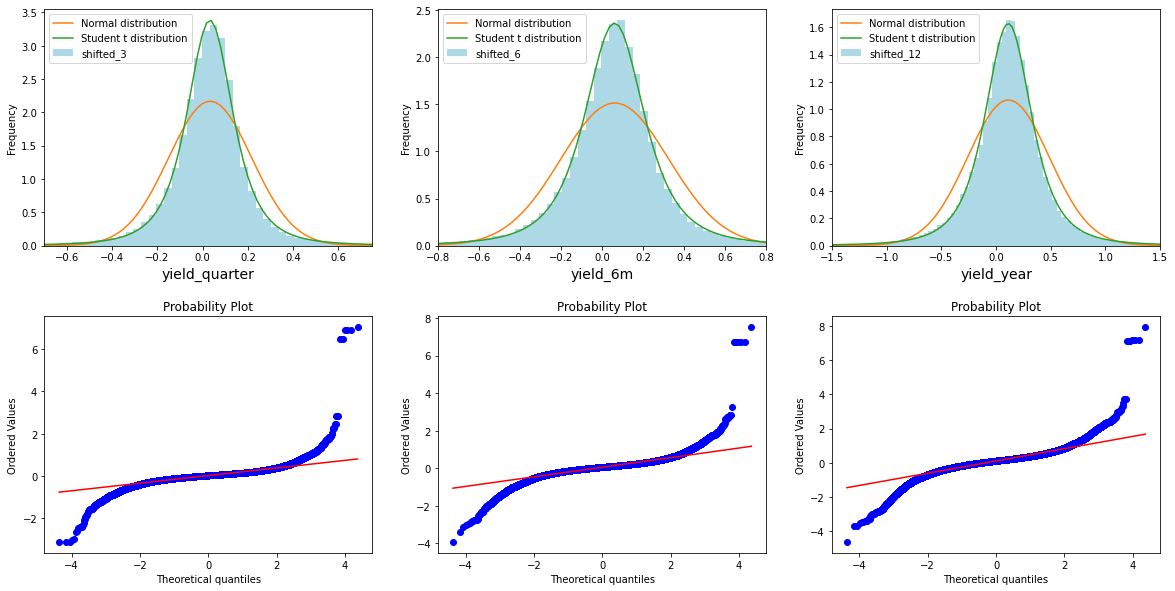

In [26]:
fig = plt.figure(figsize=(20,10))
ax11 = fig.add_subplot(231); ax12 = fig.add_subplot(232); ax13 = fig.add_subplot(233);
ax21 = fig.add_subplot(234); ax22 = fig.add_subplot(235); ax23 = fig.add_subplot(236)

# shifted_6
x = np.linspace(dd.shifted_3.min(),dd.shifted_3.max(),500)
std = 1.4826 * dd.shifted_3.mad()
mean = dd.shifted_3.median()

#ax21
sc.stats.probplot(dd.shifted_3, dist="norm", plot=ax21 )

#ax11

dd.shifted_3.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax11)
ax11.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax11.set_xlabel('yield_quarter', fontsize=14)
params = stats.t.fit(dd.shifted_3)
ax11.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax11.set_xlim(-0.7,0.75)
ax11.legend()


# shifted_3
x = np.linspace(dd.shifted_6.min(),dd.shifted_6.max(),500)
std = 1.4826 * dd.shifted_6.mad()
mean = dd.shifted_6.median()
std_n = 1.4826 * dd.shifted_6.std()
mean_n = dd.shifted_6.mean()


#ax22
sc.stats.probplot(dd.shifted_6, dist="norm", plot=ax22)

#ax12
#hist
dd.shifted_6.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax12)

#norm
ax12.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax12.set_xlabel('yield_6m', fontsize=14)

#t_dist
params = stats.t.fit(dd.shifted_6)
ax12.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax12.set_xlim(-0.8,0.8)
ax12.legend()



# shifted_12
x = np.linspace(dd.shifted_12.min(),dd.shifted_12.max(),500)
std = 1.4826 * dd.shifted_12.mad()
mean = dd.shifted_12.median()

#ax23
sc.stats.probplot(dd.shifted_12, dist="norm", plot=ax23)
#ax13
dd.shifted_12.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax13)
ax13.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax13.set_xlabel('yield_year', fontsize=14)
params = stats.t.fit(dd.shifted_12)
ax13.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax13.set_xlim(-1.5,1.5)
ax13.legend()

plt.subplots_adjust(hspace=0.3)
pylab.show()

In [27]:
shifted_1_outliers = np.array(dd[dd.groupby('company')['shifted_1'].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)

shifted_3_outliers = np.array(dd[dd.groupby('company')['shifted_3'].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)

shifted_6_outliers = np.array(dd[dd.groupby('company')['shifted_6'].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)

shifted_12_outliers = np.array(dd[dd.groupby('company')['shifted_12'].apply(lambda x: np.abs(x - x.median()) > \
                                                             (3 * 1.4826 * x.mad()))].any(axis=1).index)

outliers = [index for index in shifted_3_outliers if index not in shifted_1_outliers]
outliers = np.concatenate((shifted_1_outliers, outliers), axis=None)

outliers_1 = [index for index in shifted_12_outliers if index not in outliers]
outliers = np.concatenate((outliers_1, outliers), axis=None)

outliers_2 = [index for index in shifted_12_outliers if index not in outliers]
outliers = np.concatenate((outliers_2, outliers), axis=None)

outliers = outliers.reshape(1,-1)[0]
dd.drop(outliers, inplace = True)

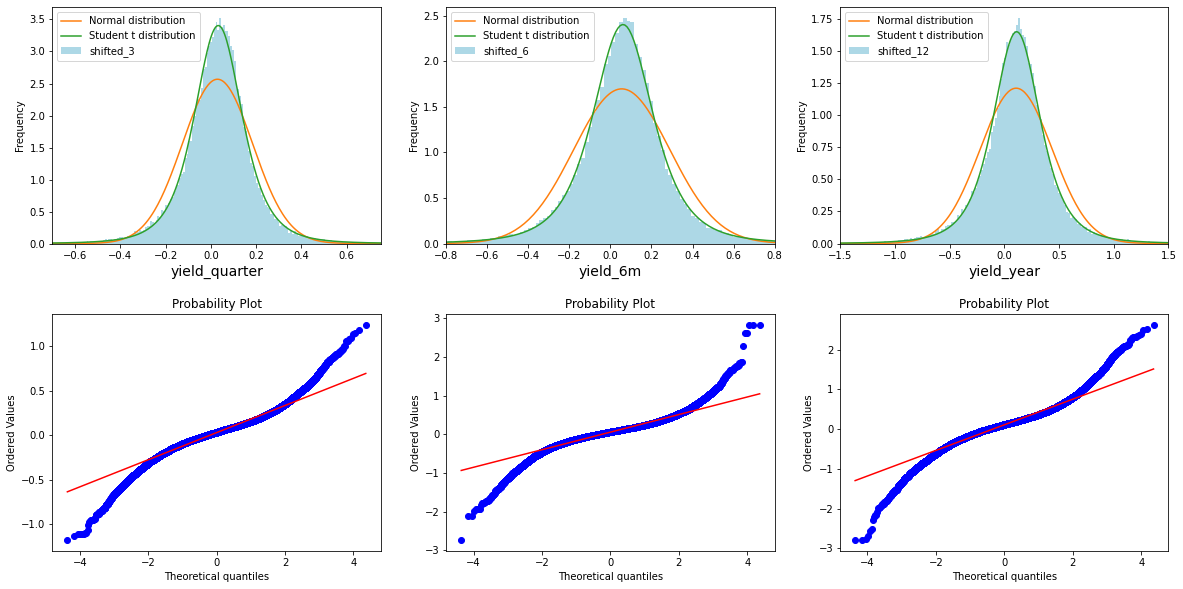

In [29]:
fig = plt.figure(figsize=(20,10))
ax11 = fig.add_subplot(231); ax12 = fig.add_subplot(232); ax13 = fig.add_subplot(233);
ax21 = fig.add_subplot(234); ax22 = fig.add_subplot(235); ax23 = fig.add_subplot(236)

# shifted_6
x = np.linspace(dd.shifted_3.min(),dd.shifted_3.max(),500)
std = dd.shifted_3.std()
mean = dd.shifted_3.mean()

#ax21
sc.stats.probplot(dd.shifted_3, dist="norm", plot=ax21 )

#ax11

dd.shifted_3.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax11)
ax11.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax11.set_xlabel('yield_quarter', fontsize=14)
params = stats.t.fit(dd.shifted_3)
ax11.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax11.set_xlim(-0.7,0.75)
ax11.legend()


# shifted_3
x = np.linspace(dd.shifted_6.min(),dd.shifted_6.max(),500)
std =  dd.shifted_6.std()
mean = dd.shifted_6.mean()


#ax22
sc.stats.probplot(dd.shifted_6, dist="norm", plot=ax22)

#ax12
#hist
dd.shifted_6.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax12)

#norm
ax12.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax12.set_xlabel('yield_6m', fontsize=14)

#t_dist
params = stats.t.fit(dd.shifted_6)
ax12.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax12.set_xlim(-0.8,0.8)
ax12.legend()



# shifted_12
x = np.linspace(dd.shifted_12.min(),dd.shifted_12.max(),500)
std = dd.shifted_12.std()
mean = dd.shifted_12.mean()

#ax23
sc.stats.probplot(dd.shifted_12, dist="norm", plot=ax23)
#ax13
dd.shifted_12.plot.hist(bins = 300, density=True, facecolor="LightBlue", ax = ax13)
ax13.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
ax13.set_xlabel('yield_year', fontsize=14)
params = stats.t.fit(dd.shifted_12)
ax13.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax13.set_xlim(-1.5,1.5)
ax13.legend()

plt.subplots_adjust(hspace=0.3)
pylab.show()

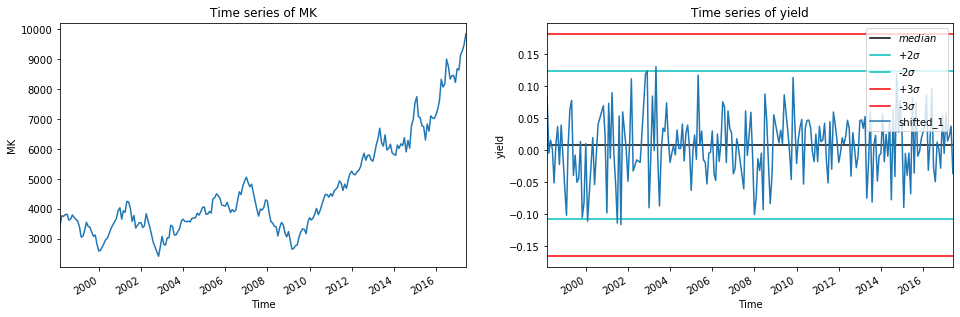

In [45]:
PNW = dd[dd.label == 'PNW']
PNW = PNW.set_index('DataDate')

median = PNW.shifted_1.median()
MAD = PNW.shifted_1.mad()
sig_robust = MAD * 1.4826

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax2.plot(PNW.index, len(PNW.shifted_1)*[median], color="k", label="$median$" )
ax2.plot(PNW.index, len(PNW.shifted_1)*[median+2*sig_robust], color='c', label="+2$\sigma$" )
ax2.plot(PNW.index, len(PNW.shifted_1)*[median-2*sig_robust], color='c', label="-2$\sigma$" )
ax2.plot(PNW.index, len(PNW.shifted_1)*[median+3*sig_robust], color='r', label="+3$\sigma$" )
ax2.plot(PNW.index, len(PNW.shifted_1)*[median-3*sig_robust], color='r', label="-3$\sigma$" )

PNW.shifted_1.plot(ax=ax2)

PNW.MK.plot(ax=ax1)
ax1.set_title("Time series of MK"); ax1.set_xlabel("Time"); ax1.set_ylabel("MK")
ax2.set_title("Time series of yield"); ax2.set_xlabel("Time"); ax2.set_ylabel('yield'); ax2.legend(loc="upper right")
plt.show()

In [11]:
dd.to_excel('New_Market_Data.xlsx')

In [ ]:
x = np.linspace(dd.log_MK.min(),dd.log_MK.max(),100)
std = 1.4826 * dd.log_MK.mad()
mean = dd.log_MK.median()
plt.figure(figsize(15,5))
plt.subplot(121)
sc.stats.probplot(dd.log_MK, dist="norm", plot=pylab)
plt.subplot(122)
dd.log_MK.plot.hist(bins = 50, density=True, facecolor="LightBlue")
plt.plot(x, stats.norm.pdf(x,mean,std), label="Normal distribution")
params = stats.t.fit(dd.log_MK)
plt.plot(x, stats.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
plt.xlabel('log_MK', fontsize=14)
plt.legend()
pylab.show()

